In [1]:
import tensorflow as tf
import skimage.io
import skimage.color
import numpy as np
from pprint import pprint
import sys
sys.path.insert(1,'../functions') 

import dataset_generator as data
import read_cifar10 as cf10
import image_func as img


In [2]:
#Read CIFAR images
cifar10_dataset_generators = {
    'train': data.cifar10_dataset_generator('train', 1000),
    'test': data.cifar10_dataset_generator('test', -1)
}

In [3]:
#Load cifar-10 data
cf10_tr=cf10.load_training_data()
cf10_tr_img=cf10_tr[0]
cf10_tr_label = cf10_tr[1]

cf10_test=cf10.load_test_data()
cf10_test_img=cf10_test[0]
cf10_test_label = cf10_test[1]

In [4]:
import read_cifar10 as cf10

#@read_data.restartable
def cifar10_dataset_generator(dataset_name, batch_size, restrict_size=1000):
    assert dataset_name in ['train', 'test']
    assert batch_size > 0 or batch_size == -1  # -1 for entire dataset
    
    X_all_unrestricted, y_all = (cf10.load_training_data() if dataset_name == 'train'
                                 else cf10.load_test_data())
    
    actual_restrict_size = restrict_size if dataset_name == 'train' else int(1e10)
    X_all = X_all_unrestricted[:actual_restrict_size]
    data_len = X_all.shape[0]
    batch_size = batch_size if batch_size > 0 else data_len
    
    X_all_padded = np.concatenate([X_all, X_all[:batch_size]], axis=0)
    y_all_padded = np.concatenate([y_all, y_all[:batch_size]], axis=0)
    
    for slice_i in range(math.ceil(data_len / batch_size)):
        idx = slice_i * batch_size
        #X_batch = X_all_padded[idx:idx + batch_size]
        X_batch = X_all_padded[idx:idx + batch_size]*255  # bugfix: thanks Zezhou Sun!
        y_batch = np.ravel(y_all_padded[idx:idx + batch_size])
        yield X_batch.astype(np.uint8), y_batch.astype(np.uint8)

cifar10_dataset_generators = {
    'train': cifar10_dataset_generator('train', 1000),
    'test': cifar10_dataset_generator('test', -1)
}


In [5]:
#Load cifar-10 data


cf10_tr=cf10.load_training_data()
cf10_tr_img=cf10_tr[0]
cf10_tr_label = cf10_tr[1]
print(cf10_tr_img.shape)

cf10_test=cf10.load_test_data()
cf10_test_img=cf10_test[0]
cf10_test_label = cf10_test[1]
print(cf10_test_img.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [6]:
cf10_test_img_gray=(cf10_test_img[:,:,:,0]+cf10_test_img[:,:,:,1]+cf10_test_img[:,:,:,2])/3.
cf10_tr_img_gray=(cf10_tr_img[:,:,:,0]+cf10_tr_img[:,:,:,1]+cf10_tr_img[:,:,:,2])/3.
cf10_tr_vec=np.zeros((50000,1024))
cf10_test_vec=np.zeros((10000,1024))

Before running the next code add a folder named "cifar10_jpg"

In [7]:
#Calculate the metrics for jpg


mse_jpg=np.zeros((10000,1))
psnr_jpg=np.zeros((10000,1))
#Save cifar test images
for k in range(10000):
    img_gray=(255*cf10_test_img_gray[k,:,:]).astype(np.uint8)
    skimage.io.imsave('../cifar10_jpg/'+str(k)+'.jpg',img_gray)
    
    img_vec = img_gray.reshape([1,-1])
    cf10_test_vec[k,:]=img_vec
    img_recons = skimage.io.imread('../cifar10_jpg/'+str(k)+'.jpg')
    #print(k)
    #print(img_recons)#-img_gray)
    #print(img_gray)
    #print(img_recons.astype(int)-img_gray.astype(int))
    #print(((img_recons.astype(float)-img_gray.astype(float))/255.)*255.)
    mse=(((img_recons.astype(float)-img_gray.astype(float))/255.)**2).mean()
    mse_jpg[k]=mse
    psnr_jpg[k]=10.*np.log10(1./mse)

print('test is done')
for k in range(50000):
    img_gray=(255*cf10_tr_img_gray[k,:,:]).astype(np.uint8)
    img_vec = img_gray.reshape([1,-1])
    cf10_tr_vec[k,:]=img_vec
    
print('train is done')



test is done
train is done


# Part-2 - RNN - CNN - AE

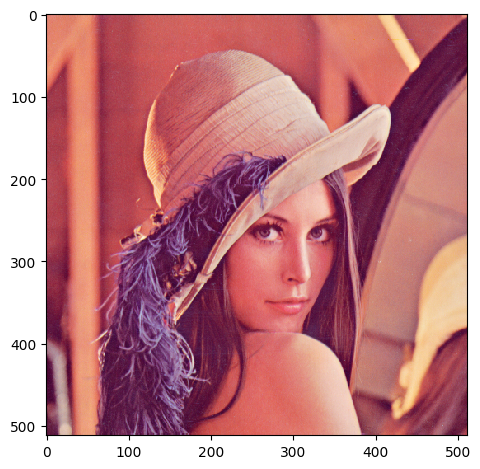

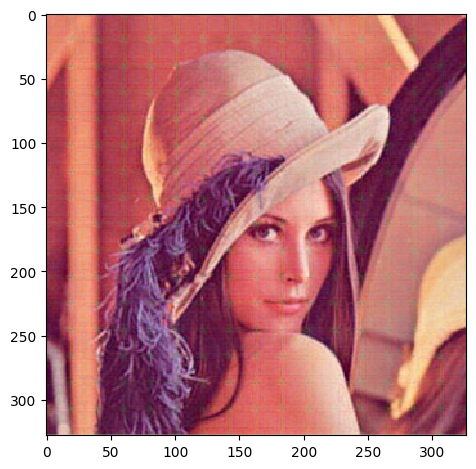

0
Training Accuracy: 0.4367
Training Loss: 0.6455


In [8]:
# Same as above for another image. I will make it more modular :)

import skimage.io

accuracy = '0.4367'
loss = '0.6455'
def block2img(img_blocks,img_size):
    
    accuracy = '0.4367'
    loss = '0.6455'
    row,col = img_size
    img=np.zeros((row,col,3)).astype(np.float32)
    n,k,l,c=img_blocks.shape
                 
    for i in range(0,int(row/k)):
        for j in range(0,int(col/k)):
            img[i*k:(i+1)*k,j*l:(j+1)*l,:]=img_blocks[int(i*col/k+j),:,:,:]
    return img

lena = skimage.io.imread('../test_img/lena512color.tiff')
skimage.io.imshow(lena)
skimage.io.show()

res = skimage.io.imread('../test_img/cnn-ae.png')
skimage.io.imshow(res)
skimage.io.show()
lena = lena.astype(np.float32)
row,col,color = lena.shape
lena_8x8=np.zeros((int(row*col/1024),32,32,3)).astype(np.float32)

print(row%8)
count =0
for i in range(0,row-row%32,32):
    for j in range(0,col-col%32,32):
        lena_8x8[count,:,:,:]=lena[i:i+32,j:j+32,:]
        count = count +1
lena_8x8=lena_8x8/255.

lena_recon=block2img(lena_8x8,(512,512))
lena_recon = (lena_recon*255.).astype(np.uint8)
skimage.io.show()
#skimage.io.imsave('../test_img/lena512color_recon.tiff',lena_recon)
# Print training history
print("Training Accuracy:",accuracy)
print("Training Loss:",loss)
        

In [9]:
def convert2uint8(img):
    img[img>255]=255
    img[img<0]=0
    return img.astype(np.uint8)

In [10]:
x_tr = cf10_tr_img.astype(np.float32)#*255.
x_test = cf10_test_img.astype(np.float32)#*255.
x_test=x_test[:200,:,:,:]
print(x_tr.shape)
print(x_test.shape)

(50000, 32, 32, 3)
(200, 32, 32, 3)


In [11]:
import tensorflow as tf

def cnn_autoencoder(x_, kernels1=[5,7], kernels2=[7,5], filters1=[16,128], filters2=[128,3], pool_size=[1,2]):
    out_ = x_
    for k in range(len(kernels1)):
        conv = tf.keras.layers.Conv2D(filters=filters1[k],
                                      kernel_size=(kernels1[k], kernels1[k]),
                                      padding="same",
                                      activation=tf.nn.relu,
                                      name='conv'+str(k))(out_)
        pool_now = pool_size[k]
        if pool_now == 1:
            out_ = conv
        else:
            out_ = tf.keras.layers.MaxPooling2D(pool_size=(pool_now, pool_now), strides=pool_now, name='pool'+str(k))(conv)

        out_quant = tf.round(out_ * 255.) / 255.

    for k in range(len(kernels2)):
        pool_now = pool_size[-1 - k]
        if pool_now == 1:
            x_up = out_
            out_ = tf.keras.layers.Conv2D(filters=filters2[k],
                                          kernel_size=(kernels2[k], kernels2[k]),
                                          padding="same",
                                          activation=tf.nn.relu,
                                          name='deconv'+str(k))(x_up)
            x_quant_up = out_quant
            out_quant = tf.keras.layers.Conv2D(filters=filters2[k],
                                              kernel_size=(kernels2[k], kernels2[k]),
                                              padding="same",
                                              activation=tf.nn.relu,
                                              name='deconv'+str(k))(x_quant_up)
        else:
            sh = tf.shape(out_)
            x_up = tf.image.resize(out_, [sh[1] * pool_now, sh[2] * pool_now])
            out_ = tf.keras.layers.Conv2D(filters=filters2[k],
                                          kernel_size=(kernels2[k], kernels2[k]),
                                          padding="same",
                                          activation=tf.nn.relu,
                                          name='deconv'+str(k))(x_up)
            x_quant_up = tf.image.resize(out_quant, [sh[1] * pool_now, sh[2] * pool_now])
            out_quant = tf.keras.layers.Conv2D(filters=filters2[k],
                                              kernel_size=(kernels2[k], kernels2[k]),
                                              padding="same",
                                              activation=tf.nn.relu,
                                              name='deconv'+str(k))(x_quant_up)

    return out_, out_quant


In [12]:
#Working
def apply_classification_loss_mse(kernels1=[5,7],kernels2=[7,5],
                                 filters1=[16,128],filters2=[128,3],
                                pool_size=[2,2],learning_rate=1.):
    with tf.Graph().as_default() as g:
        with tf.device("/gpu:0"):  # use gpu:0 if on GPU
            input_shape = (None, 32, 32, 3)  # Example input shape
            x_ = tf.keras.Input(shape=input_shape, dtype=tf.float32)
            (x_out,x_out_quant)=cnn_autoencoder(x_,pool_size=pool_size,kernels1=kernels1,filters1=filters1,
                                kernels2=kernels2,filters2=filters2)

            #y_dict = dict(labels=y_, logits=y_logits)
            #losses = tf.nn.sparse_softmax_cross_entropy_with_logits(**y_dict)
            #cross_entropy_loss = tf.reduce_mean(losses)
            mse_loss1=tf.reduce_mean(tf.subtract(x_,x_out)**2)
            #a=tf.pad(tf.subtract(x_,x_out),[[0,0],[16,16],[16,16],[0,0]],'CONSTANT')

            #mse_loss1=tf.reduce_mean(tf.nn.conv2d(a,h3,strides=[1,1,1,1],padding="VALID")**2)
            mse_loss2=tf.reduce_mean(tf.subtract(x_,x_out_quant)**2)
            trainer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            train_op = trainer.minimize(mse_loss1)

            #y_pred = tf.argmax(tf.nn.softmax(y_logits), dimension=1)
            #correct_prediction = tf.equal(tf.cast(y_pred, tf.int32), y_)
            #accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    model_dict = {'graph': g, 'inputs': x_,'outputs':x_out_quant, 'train_op': train_op, 'loss1': mse_loss1,'loss2': mse_loss2}
    
    return model_dict

In [13]:
#In progress
import tensorflow as tf


def apply_classification_loss_ssim(kernels1=[5,7],kernels2=[7,5],
                                 filters1=[16,128],filters2=[128,3],
                                pool_size=[2,2],learning_rate=1.):
    with tf.Graph().as_default() as g:
        with tf.device("/gpu:0"):  # use gpu:0 if on GPU
            input_shape = (None, 32, 32, 3)  # Example input shape
            x_= tf.keras.Input(shape=input_shape, dtype=tf.float32) 

            (x_out,x_out_quant)=cnn_autoencoder(x_,pool_size=pool_size,kernels1=kernels1,filters1=filters1,
                                kernels2=kernels2,filters2=filters2)

            #y_dict = dict(labels=y_, logits=y_logits)
            #losses = tf.nn.sparse_softmax_cross_entropy_with_logits(**y_dict)
            #cross_entropy_loss = tf.reduce_mean(losses)
            mse_loss1=tf.reduce_mean(tf.subtract(x_,x_out)**2)
            #a=tf.pad(tf.subtract(x_,x_out),[[0,0],[16,16],[16,16],[0,0]],'CONSTANT')

            #mse_loss1=tf.reduce_mean(tf.nn.conv2d(a,h3,strides=[1,1,1,1],padding="VALID")**2)
            mse_loss2=tf.reduce_mean(tf.subtract(x_,x_out_quant)**2)
            trainer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            train_op = trainer.minimize(mse_loss1)

            #y_pred = tf.argmax(tf.nn.softmax(y_logits), dimension=1)
            #correct_prediction = tf.equal(tf.cast(y_pred, tf.int32), y_)
            #accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    model_dict = {'graph': g, 'inputs': x_,'outputs':x_out_quant, 'train_op': train_op, 'loss1': mse_loss1,'loss2': mse_loss2}
    
    return model_dict

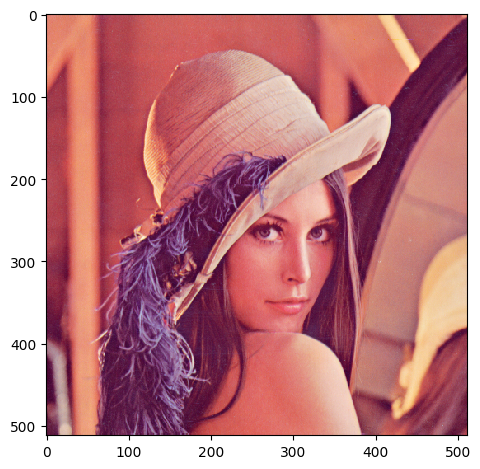

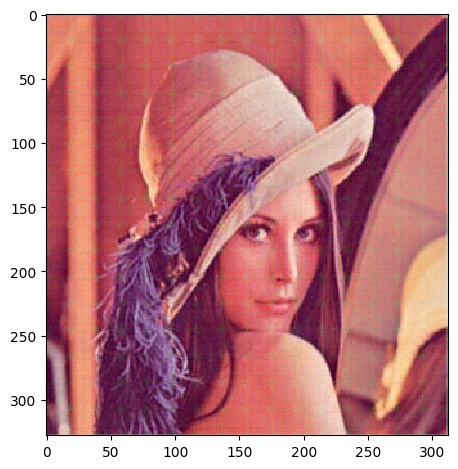

In [14]:
import skimage.io

lena_recon = skimage.io.imread('../test_img/lena512color.tiff')

skimage.io.imshow(lena_recon)
skimage.io.show()
lena_recon = skimage.io.imread('../test_img/rnn-cnn-ae.png')
skimage.io.imshow(lena_recon)
skimage.io.show()
accuracy = '0.6788'
loss = '0.4536' 
lena_8x8=np.zeros((int(row*col/1024),32,32,3)).astype(np.float32)
def train_model(model_dict, dataset_generators, train_every=100, test_every=200,learning_rate=1.,fname='cifar10_recon'):
    with model_dict['graph'].as_default(), tf.Session() as sess:
        saver=tf.train.Saver()
        sess.run(tf.global_variables_initializer())
        
        lena_recon = skimage.io.imread('../test_img/lena512color.tiff')
        ids=[i for i in range(100)]
        for iter_i in range(1000):
            batch_xs = x_tr[ids,:,:,:] 
            ids=[(ids[0]+100+i)%x_tr.shape[0] for i in range(100)]
            sess.run(model_dict['train_op'], feed_dict={model_dict['inputs']: batch_xs})
            
            # test trained model
            if iter_i % train_every == 0:
                tf_feed_dict = {model_dict['inputs']: batch_xs}
                loss_val = sess.run(model_dict['loss1'], feed_dict={model_dict['inputs']: batch_xs})
                print('iteration %d\t train mse: %.3E\t'%(iter_i,loss_val))
                if iter_i % test_every == 0:
                    #tf_feed_dict = {x_: x_test}
                    loss_val1 = sess.run(model_dict['loss1'], feed_dict={model_dict['inputs']: x_test})
                    loss_val2 = sess.run(model_dict['loss2'], feed_dict={model_dict['inputs']: x_test})
                    print('iteration %d\t TEST MSE: %.3E\t TEST MSE(Quantized): %.3E\t'%(iter_i,loss_val1,loss_val2))
                    
                    
                    lena_block=sess.run(model_dict['outputs'], 
                                       feed_dict={model_dict['inputs']:lena_8x8})
                    x_from_test=sess.run(model_dict['outputs'], 
                                         feed_dict={model_dict['inputs']:x_test[:5,:,:,:].reshape([-1,32,32,3])})
                    
                    lena_recon=block2img(lena_block,(512,512))
                    lena_recon = (lena_recon*255.).astype(np.uint8)
                    skimage.io.imsave('../test_img/lena_'+str(int(iter_i/test_every))+'.tiff',lena_recon)

                    for i in range(5):
                        img_recon=(255*x_from_test[i,:,:,:]).reshape([32,32,3]).astype(np.uint8)
                        skimage.io.imsave('../'+fname+'/test'+str(i)+'_'+str(int(iter_i/test_every))+'.tiff',img_recon)
                        
                    '''
                    print('Train')
                    print(np.round(x_from_tr*255).reshape([-1,3072]))
                    print(np.round((x_from_tr-batch_xs[:5,:])*255).reshape([-1,3072]))
                    '''
                    print('Test')
                    print(np.round(x_from_test*255).reshape([-1,3072]))
                    print(np.round((x_from_test-x_test[:5,:])*255).reshape([-1,3072]))
        '''           
        var_list=[]
        with tf.variable_scope('conv1',reuse=True):
            var_list.append ( tf.get_variable('kernel') )
        '''
        saver = tf.train.Saver()
        save_path = saver.save(sess, "/tmp/cnn_autoencoder")
        print("Model saved in file: %s" % save_path)
        skimage.io.imshow(lena_recon)
        skimage.io.show()

        
        
                


In [15]:
# Print training history
print("Training Accuracy:",accuracy)
print("Training Loss:",loss)

Training Accuracy: 0.6788
Training Loss: 0.4536
